# Perceptron et MLP

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Fonctions d'activations et leurs dérivées
Commencons par définir et tracer quelques fonctions d'activations ainsi que leurs dérivées. Ces fonctions pernnent entrée un vecteur numpy et retourne un vecteur numpy.

### Fonction sigmoid
La fonction sigmoid est données par $\Phi(x)=\frac{1}{1+\exp(-x)}$.

In [2]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

Cette fonction ressemble à une rampe douce :

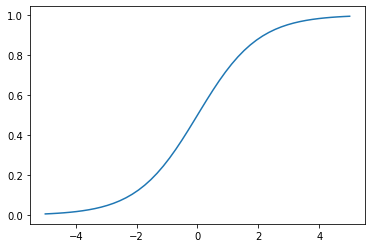

In [3]:
x = np.linspace(-5,5)
f=plt.plot(x,sigmoid(x))

La dérivée de celle ci est donc :
$$
\begin{align}
\Phi'(x) &= \frac{\exp(-x)}{(1+\exp(-x))^2}\\
&=\frac{1}{(1+\exp(-x))}\frac{\exp(-x)}{(1+\exp(-x))}\\
&=\Phi(x)(1-\Phi(x))
\end{align}
$$
### Question 
coder la fonction der_sigmoid(x) qui clacul la dérivée de la fonction sigmoid en un point x. Cette fonction prend entrée un vecteur numpy et retourne un vecteur numpy. Observer son évolution.

In [4]:
def der_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

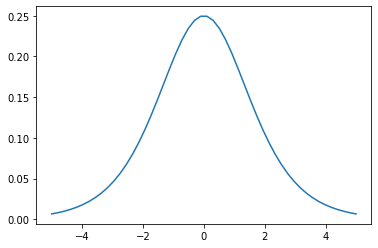

In [5]:
f=plt.plot(x,der_sigmoid(x))

### Fonction tanh
Faisons de même pour la fonction d'activation $tanh(x)$

In [6]:
def tanh(x):
    return np.tanh(x)

In [7]:
def der_tanh(x):
    return 1-np.power(np.tanh(x),2)

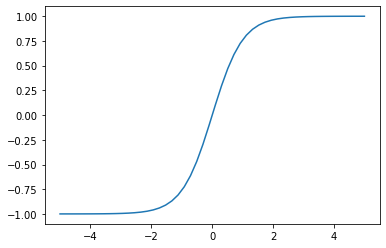

In [8]:
f=plt.plot(x,tanh(x))

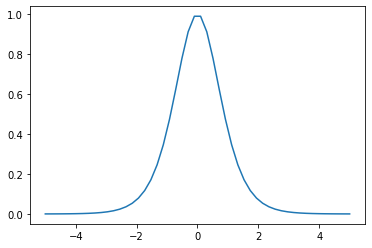

In [9]:
f=plt.plot(x,der_tanh(x))

### Fonction Relu

In [10]:
def relu(x):
    v=np.zeros(x.shape)
    v[x>0]=x[x>0]
    return v

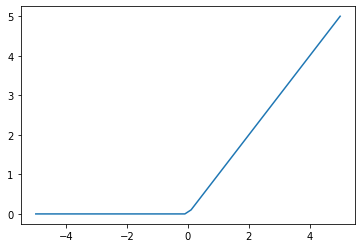

In [11]:
f=plt.plot(x,relu(x))

### Question
Coder une focntion calulant la dérivée de la fonction relu et tracer sa courbe entre $[-5,5]$

In [12]:
def der_relu(x):
    v=np.zeros(x.shape)
    v[x>0]=1
    return v

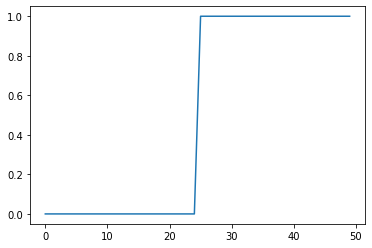

In [13]:
f=plt.plot(der_relu(x))

## Fonction de cout
Définissons la fonction de cout de cross entropy pour la classification binaire. Cette fonction prend deux arguments la valeur prédite $\tilde{y}\in[0,1]$ et la vraie valeure $y\in\{0,1\}$ et mesure l'écart.
$$L(\tilde{y},y)=-y\log(\tilde(y))-(1-y)\log(1-\tilde{y})$$
Pour éviter les problème numérique nous capeerons les valeurs de $\tilde{y}$.

In [14]:
def cross_entropy(yh,y):
    th = 0.000001
    yh[yh<th] = th
    yh[yh>(1-th)] = 1-th
    return -y*np.log(yh)-(1-y)*np.log(1-yh)

### Questions 
Ecrire une foncion python qui calcul $\frac{\delta L'(\tilde{y},y)}{\delta\tilde{y}}$. Caper également les valeur de $\tilde{y}$.

In [15]:
def der_cross_entropy(yh,y):
    th= 0.000001
    yh[yh<th] = th
    yh[yh>(1-th)] = 1-th
    return -y/yh+(1-y)/(1-yh)

## Perceptrons
Commencons par nous créer un jeu de données de test en 2 dimension.

In [16]:
X = np.concatenate([np.random.normal([-5,-5],size=[100,2]),
                    np.random.normal([-5,5],size=[100,2]),
                    np.random.normal([5,-5],size=[100,2]),
                    np.random.normal([5,5],size=[100,2])])
y = np.concatenate([np.ones(200),np.zeros(200)])

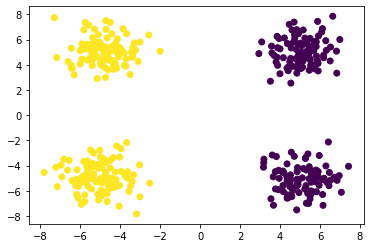

In [17]:
f= plt.scatter(X[:,0],X[:,1],c=y)

Voici maintenant le squelette d'une classe python qui imlémente un perceptron.

In [18]:
class Perceptron():
    # inialisation
    def __init__(self,input_size):
        # taille des entrées
        self.input_size = input_size
        # vecteur de poids de taille d,1
        self.w = np.random.normal(size=(self.input_size,1))
    
    # calcul de la sortie
    def forward(self,X):
        # multiplication matricielle
        z = np.matmul(X,self.w)
        # fonction d'activation sigmoide
        yh = sigmoid(z)
        # remise en forme vectorielle
        return yh.reshape((X.shape[0],))
    
    # calcul du gradient pour un semble de données X de taille N,d et y de taille N 
    def backward(self,X,y):
        # calcul des sorties
        yh = self.forward(X)
        # dérivée de la fonction de cout
        dce  = der_cross_entropy(yh,y)
        # dérivée de la fonction d'activation
        dact = der_sigmoid(yh)
        # produit des deux de taille N,1
        eta = np.reshape(dce*dact,(X.shape[0],1))
        # repetitions pour obtennir une matrice N,d
        Eta = np.repeat(eta,repeats=self.input_size,axis=1)
        # calcul du gradient : moyenne des eta*X
        G = np.mean(Eta*X,axis=0)
        # mise dans le bon sens
        return np.reshape(G,(self.input_size,1))
    
    # descente de gradient
    # step_size : pas du gradient
    def grad_desc(self,X,y,step_size):
        # calcul du gradient
        grad = self.backward(X,y)
        # descente mise a jour des poids
        self.w = self.w - step_size*grad
    
    # apprentissage batch
    # epoch : nombre de balyage du jeu de données 
    def train_batch(self,X,y,step_size,epoch):
        # vecteur permettant de stocker l'évolution de l'erreur
        hist = [self.loss(X,y)]
        # pour un nombre d'epoque données
        for r in range(0,epoch):
            # descente de gradient
            self.grad_desc(X,y,step_size)
            # calcul de la fonction de cout
            l=self.loss(X,y)
            # diminution du pas si nécessaire
            if(l>hist[-1]):
                step_size=step_size*0.5
            #print("Loss : {}".format(l))
            hist.append(l)
        return np.array(hist)
        
    # apprentissage sgd 
    # batch_size : taille des batchs
    def train_sgd(self,X,y,step_size,epoch,batch_size):
        # vecteur permettant de stocker l'évolution de l'erreur
        hist = [self.loss(X,y)]
        # combien de batch complés peut on faire 
        nb_batchs = np.floor(X.shape[0]/batch_size)
        # pour chaque balayage
        for r in range(0,epoch):
            # permuation aléatoire du jeu de données
            perm = np.random.permutation(X.shape[0])
            # pour chaque batch
            for b in range(0,int(nb_batchs)):
                # recupérations des indices des lignes composant le batch
                c_batch= perm[range(b*batch_size,(b+1)*batch_size)]
                # descente de gradient surle batch
                self.grad_desc(X[c_batch,:],y[c_batch],step_size)
            # calcul de l'erreur
            l=self.loss(X,y)
            #print("Loss : {}".format(l))
            hist.append(l)
        return np.array(hist)
    
    # fonction de cout
    def loss(self,X,y):
        yh = self.forward(X)
        L = cross_entropy(yh,y)
        return np.mean(L)

### Usage
Aprés avoir lu attentivement le code nous pouvons tester notre perceptrons sur les données d'exemple. 

In [19]:
# creation d'un perceptrons
per = Perceptron(2)
# prediction
yh  = per.forward(X)
# valeur initiale de la fonction de cout
print("Loss : {}".format(per.loss(X,y)))

Loss : 6.204217504770379


Essayons de faire un balayage et calculons la nouvelle valeur de l'erreur.

In [20]:
per.train_batch(X,y,0.0001,1)
print("Loss : {}".format(per.loss(X,y)))

Loss : 3.733428612772104


Avant de faire plusieur passe et d'observer l'évolution de la fonction de cout.

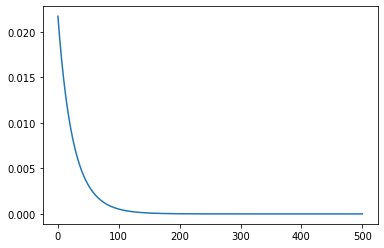

In [21]:
per = Perceptron(2)
h = per.train_batch(X,y,0.01,500)
f=plt.plot(h)

Nous pouvons aussi visualiser les predictions du perceptrons.

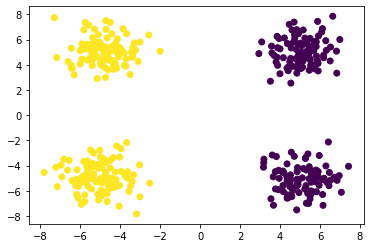

In [22]:
f=plt.scatter(X[:,0],X[:,1],c=per.forward(X)>0.5)

Essayons avec un autre jeu de données :

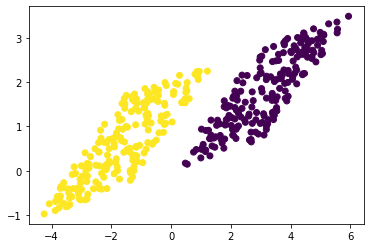

In [23]:
X1=np.concatenate([-1*np.random.rand(200,1)-0.5,np.random.rand(200,1)],axis=1)
X2=np.concatenate([np.random.rand(200,1),np.random.rand(200,1)],axis=1)
X=np.matmul(np.concatenate([X1,X2]),np.reshape([3,0.7,3,2.8],(2,2)))
y=np.concatenate([np.ones(200),np.zeros(200)])
f=plt.scatter(X[:,0],X[:,1],c=y)

### Questions 

- Créer un matrice numpy qui contient X et une colonne de 1 supplémentaire, cela permettra de prendre en compte le biais dans l'appentissage. 
- Créer ensuite un perceptron de taille 3
- Faire un apprentissage batch de 200 époques avec un pas de 0.05 initialement.
- Visualiser les résultats
- Faites varier les paramètres nombre d'époques et pas de gradient

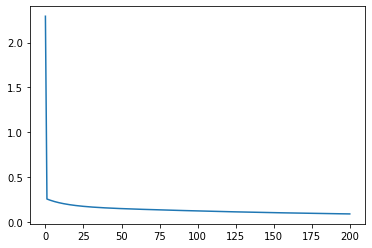

In [24]:
Xb=np.concatenate([X,np.ones((400,1))],axis=1)
per = Perceptron(3)
h = per.train_batch(Xb,y,0.05,200)
f=plt.plot(h)

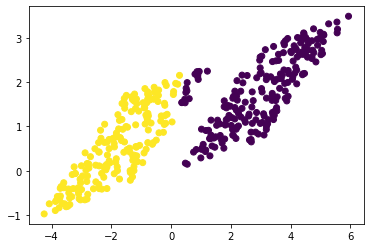

In [25]:
f=plt.scatter(X[:,0],X[:,1],c=per.forward(Xb)>0.5)

# Questions

- Créer une methode train_sgd dans la classe perceptrons. cette méthode prend en entrée X,y, le pas du gradient, le nombre d'époque et la taille des batchs. Pour chaque époque elle mélange le jeux de données (np.random.permutation) et mets a jour les poids après chaque batchs. 
- Tester la avec le code suivant.
- Faites varier les paramètres.
- Comparer avec l'apprentissage batch.

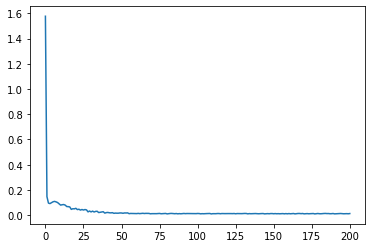

In [26]:
Xb=np.concatenate([X,np.ones((400,1))],axis=1)
per = Perceptron(3)
h = per.train_sgd(Xb,y,0.05,200,20)
f=plt.plot(h)

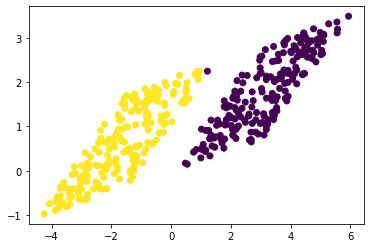

In [27]:
f=plt.scatter(X[:,0],X[:,1],c=per.forward(Xb)>0.5)

## MLP

Regardons maintenant un jeu de données un tout petit peu plus compliqué

In [28]:
X = np.concatenate([np.random.normal([-5,-5],size=[100,2]),
                    np.random.normal([5,5],size=[100,2]),
                    np.random.normal([5,-5],size=[100,2]),
                    np.random.normal([-5,5],size=[100,2])])
y = np.concatenate([np.ones(200),np.zeros(200)])

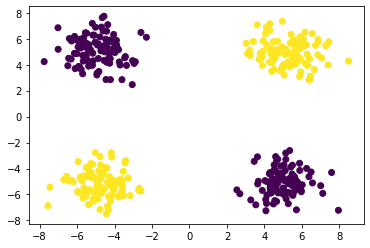

In [29]:
f=plt.scatter(X[:,0],X[:,1],c=y)

### Questions
- Créer un perceptrons pour ces données avec biais et sans biais
- Essayez de faire l'apprentissage pas de 0.001, 100 époques et batch de tailles 20
- visualissez les résultats
- Que remarquer vous ?

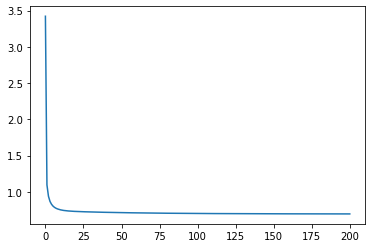

In [32]:
per = Perceptron(3)
Xb = np.concatenate([X,np.ones((X.shape[0],1))],axis=1) 
h=per.train_sgd(Xb,y,0.001,200,10)
f=plt.plot(h)

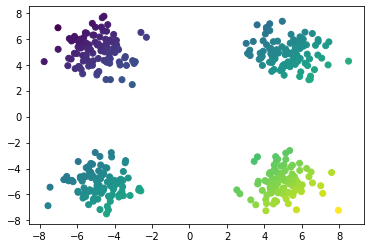

In [33]:
f=plt.scatter(X[:,0],X[:,1],c=per.forward(Xb))

### Questions

- Créer un MLP avec keras pour résoudre ce problème avec 1 couche caché et activation relu. 
- Voir la documentation de keras.layers.Input,Dense et keras.models.Model et keras.utils.to_categorical
- Utiliser les méthodes compile, fit et predict
- la derniere couche doit être une couche softmax avec deux sorties et y doit être recodée en une matrice binaire N,2
- Faire varier les paramètres et observer




In [34]:
# definition d'un mlp avec keras
from keras.layers import Layer,Input, Dense
from keras.models import Model


inputs = Input(shape=(X.shape[1],)) 

hidden = Dense(32,activation='relu')(inputs)

outputs = Dense(2, activation='softmax')(hidden)

mlp = Model(inputs,outputs)

In [35]:
mlp.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [36]:
from keras.utils import to_categorical
y_bin = to_categorical(y)

In [37]:
hist = mlp.fit(X,y_bin,batch_size=20,epochs=100)

Epoch 1/100
20/20 [==============================] - 0s 534us/step - loss: 0.9191 - accuracy: 0.6800
Epoch 2/100
20/20 [==============================] - 0s 504us/step - loss: 0.4770 - accuracy: 0.7575
Epoch 3/100
20/20 [==============================] - 0s 486us/step - loss: 0.2339 - accuracy: 0.9875
Epoch 4/100
20/20 [==============================] - 0s 504us/step - loss: 0.1347 - accuracy: 1.0000
Epoch 5/100
20/20 [==============================] - 0s 523us/step - loss: 0.0909 - accuracy: 1.0000
Epoch 6/100
20/20 [==============================] - 0s 512us/step - loss: 0.0666 - accuracy: 1.0000
Epoch 7/100
20/20 [==============================] - 0s 471us/step - loss: 0.0515 - accuracy: 1.0000
Epoch 8/100
20/20 [==============================] - 0s 511us/step - loss: 0.0410 - accuracy: 1.0000
Epoch 9/100
20/20 [==============================] - 0s 501us/step - loss: 0.0337 - accuracy: 1.0000
Epoch 10/100
20/20 [==============================] - 0s 497us/step - loss: 0.0282 - accura

20/20 [==============================] - 0s 506us/step - loss: 6.5571e-04 - accuracy: 1.0000
Epoch 81/100
20/20 [==============================] - 0s 515us/step - loss: 6.3955e-04 - accuracy: 1.0000
Epoch 82/100
20/20 [==============================] - 0s 530us/step - loss: 6.2437e-04 - accuracy: 1.0000
Epoch 83/100
20/20 [==============================] - 0s 520us/step - loss: 6.0911e-04 - accuracy: 1.0000
Epoch 84/100
20/20 [==============================] - 0s 465us/step - loss: 5.9425e-04 - accuracy: 1.0000
Epoch 85/100
20/20 [==============================] - 0s 492us/step - loss: 5.8015e-04 - accuracy: 1.0000
Epoch 86/100
20/20 [==============================] - 0s 522us/step - loss: 5.6686e-04 - accuracy: 1.0000
Epoch 87/100
20/20 [==============================] - 0s 566us/step - loss: 5.5314e-04 - accuracy: 1.0000
Epoch 88/100
20/20 [==============================] - 0s 463us/step - loss: 5.4067e-04 - accuracy: 1.0000
Epoch 89/100
20/20 [==============================] - 0s 47

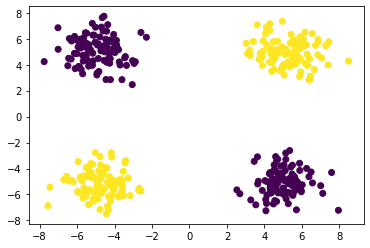

In [38]:
yh = mlp.predict(X)[:,1]>0.5
f=plt.scatter(X[:,0],X[:,1],c=yh)